In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchdyn.datasets import ToyDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [75]:
def eight_gaussians(n, dim=2, scale=1, var=1):
    if dim < 2:
        raise ValueError("dim must be at least 2")

    centers_2d = [
        (1, 0), (-1, 0), (0, 1), (0, -1),
        (1/np.sqrt(2), 1/np.sqrt(2)),
        (1/np.sqrt(2), -1/np.sqrt(2)),
        (-1/np.sqrt(2), 1/np.sqrt(2)),
        (-1/np.sqrt(2), -1/np.sqrt(2))
    ]
    centers_2d = torch.tensor(centers_2d) * scale  # Shape (8, 2)
    
    centers = torch.zeros(8, dim)
    centers[:, :2] = centers_2d  # Higher dimensions remain zero

    m = torch.distributions.MultivariateNormal(
        loc=torch.zeros(dim),
        covariance_matrix=var * torch.eye(dim)
    )


    labels = torch.multinomial(torch.ones(8), n, replacement=True)  # Shape (n,)
    
    # Select centers corresponding to labels
    selected_centers = centers[labels]  # Shape (n, dim)
    
    noise = m.sample((n,))
    data = selected_centers + noise
    
    return data, labels

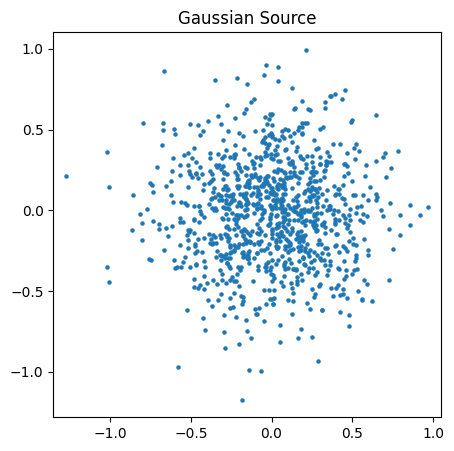

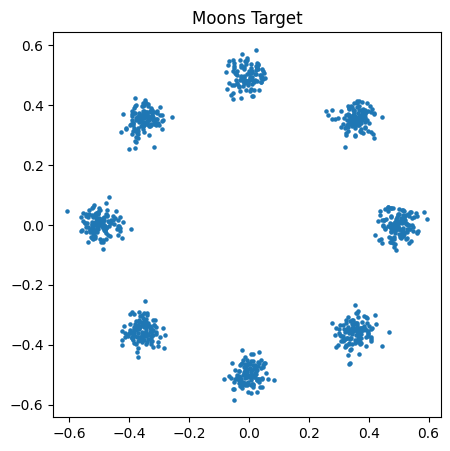

In [76]:

n_samples = 1000
data_dim = 10

x0 = torch.randn(n_samples, data_dim)/np.sqrt(data_dim)

x1, labels = eight_gaussians(n_samples, data_dim, scale=5, var=0.1)
x1 = x1/(data_dim)
t = torch.rand(n_samples, 1)
y = torch.nn.functional.one_hot(labels, num_classes=8).float()

batch_size=256

dataset = TensorDataset(x0, x1, t, y)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Visualize source & target
plt.figure(figsize=(5,5))
plt.scatter(x0[:,0], x0[:,1], s=5)
plt.title("Gaussian Source")
plt.axis("equal")
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(x1[:,0], x1[:,1], s=5)
plt.title("Moons Target")
plt.axis("equal")
plt.show()

In [77]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        z_mean = self.fc_mu(h)
        z_logvar = self.fc_logvar(h)
        return z_mean, z_logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 512)
        self.fc_out = nn.Linear(512, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc(z))
        x_reconst = torch.sigmoid(self.fc_out(h))
        return x_reconst

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def reparameterize(self, z_mean, z_logvar):
        std = torch.exp(0.5 * z_logvar)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def forward(self, x):
        z_mean, z_logvar = self.encoder(x)
        z = self.reparameterize(z_mean, z_logvar)
        x_reconst = self.decoder(z)
        return x_reconst, z_mean, z_logvar

In [78]:
device = 'cuda'
latent_dim = 2
vae = VAE(data_dim, latent_dim).to(device)

In [79]:
optimizer = optim.Adam(vae.parameters(), lr=1e-5)
criterion = nn.MSELoss()

def loss_function(x, x_reconst, z_mean, z_logvar):
    recon_loss = criterion(x_reconst, x)
    kl_div = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return recon_loss + kl_div

In [80]:
epochs = 1000
vae.train()

for epoch in tqdm(range(epochs)):
    total_loss = 0
    for _, x1_batch, _, _ in loader:
        x1 = x1_batch.to(device) 
        x_reconst, z_mean, z_logvar = vae(x1)
        loss = loss_function(x1, x_reconst, z_mean, z_logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if epoch % 100 == 0:
        print(f"Epoch {epoch + 1}, Loss: {total_loss :.4f}")


  1%|          | 11/1000 [00:00<00:18, 52.88it/s]

Epoch 1, Loss: 14.3149


 11%|█         | 109/1000 [00:01<00:12, 69.13it/s]

Epoch 101, Loss: 1.3446


 21%|██▏       | 214/1000 [00:03<00:11, 67.53it/s]

Epoch 201, Loss: 0.5605


 31%|███       | 312/1000 [00:04<00:12, 55.56it/s]

Epoch 301, Loss: 0.3824


 41%|████      | 411/1000 [00:06<00:08, 67.55it/s]

Epoch 401, Loss: 0.2962


 51%|█████     | 509/1000 [00:07<00:07, 67.75it/s]

Epoch 501, Loss: 0.2428


 61%|██████    | 607/1000 [00:09<00:05, 67.69it/s]

Epoch 601, Loss: 0.2010


 71%|███████   | 712/1000 [00:11<00:04, 67.52it/s]

Epoch 701, Loss: 0.1784


 81%|████████  | 810/1000 [00:12<00:03, 62.88it/s]

Epoch 801, Loss: 0.1618


 91%|█████████ | 908/1000 [00:14<00:01, 67.79it/s]

Epoch 901, Loss: 0.1495


100%|██████████| 1000/1000 [00:15<00:00, 64.89it/s]


In [81]:
for param in vae.parameters():
    param.requires_grad = False
    
for param in vae.encoder.fc_mu.parameters():
    param.requires_grad = True
    
for param in vae.encoder.fc_logvar.parameters():
    param.requires_grad = True

In [82]:
from typing import List

class Net(nn.Module):
    def __init__(self, in_dim: int, z_dim: int, out_dim: int, h_dims: List[int], n_frequencies: int) -> None:
        super().__init__()
        ins = [in_dim + 2 * n_frequencies + z_dim] + h_dims
        outs = h_dims + [out_dim]
        self.n_frequencies = n_frequencies
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(in_d, out_d), nn.LeakyReLU())
            for in_d, out_d in zip(ins, outs)
        ])
        self.top = nn.Sequential(nn.Linear(out_dim, out_dim))
    
    def time_encoder(self, t: torch.Tensor) -> torch.Tensor:
        freq = 2 * torch.arange(self.n_frequencies, device=t.device) * torch.pi
        t_proj = t * freq[None, :]
        return torch.cat([t_proj.cos(), t_proj.sin()], dim=-1)
    
    def forward(self, t: torch.Tensor, x: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        te = self.time_encoder(t)
        h = torch.cat([x, te, z], dim=-1)
        for layer in self.layers:
            h = layer(h)
        return self.top(h)

model = Net(in_dim=data_dim, z_dim=latent_dim, out_dim=data_dim, h_dims=[128, 128], n_frequencies=4).to(device)
optimizer = optim.Adam(list(model.parameters()) + list(vae.encoder.fc_mu.parameters()) +
    list(vae.encoder.fc_logvar.parameters()), lr=1e-3)
loss_fn = nn.MSELoss()
num_epoches = 4200

In [83]:
loss_history = []
for epoch in tqdm(range(num_epoches)):
    total_loss = 0.0
    for x0_batch, x1_batch, t_b, y_b in loader:
        
        # Interpolated positions and true vector u_t
        xt = (1 - t_b) * x0_batch + t_b * x1_batch
        ut = x1_batch - x0_batch  # (x1_batch - x0_batch) / (t_batch * (1 - t_batch))
        xt, t_b, ut, x1 = [t.to(device) for t in (xt, t_b, ut, x1_batch)]
        
        z_mean, z_logvar = vae.encoder(x1)
        z_b = vae.reparameterize(z_mean, z_logvar)
        # z_b = torch.randint(1,(y_b.shape[0],2)).to(device)
        y_b = y_b.to(device)
        
        optimizer.zero_grad()
        v_pred = model(t_b, xt, z_b)
        loss = loss_fn(v_pred, ut)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * xt.size(0)
    if epoch % 100 == 0:
        print(f"Epoch {epoch + 1}, Loss: {total_loss :.4f}")
    loss_history.append(total_loss / n_samples)

  0%|          | 14/4200 [00:00<01:02, 66.55it/s]

Epoch 1, Loss: 136.9291


  3%|▎         | 112/4200 [00:01<01:15, 54.37it/s]

Epoch 101, Loss: 30.1138


  5%|▌         | 210/4200 [00:03<01:00, 66.35it/s]

Epoch 201, Loss: 23.0166


  7%|▋         | 308/4200 [00:04<01:00, 64.60it/s]

Epoch 301, Loss: 21.2759


 10%|▉         | 413/4200 [00:06<00:56, 67.04it/s]

Epoch 401, Loss: 20.2431


 12%|█▏        | 508/4200 [00:07<00:55, 66.40it/s]

Epoch 501, Loss: 19.2238


 15%|█▍        | 613/4200 [00:09<00:56, 63.14it/s]

Epoch 601, Loss: 18.7109


 17%|█▋        | 711/4200 [00:11<00:51, 67.98it/s]

Epoch 701, Loss: 18.0396


 19%|█▉        | 810/4200 [00:12<00:51, 66.00it/s]

Epoch 801, Loss: 17.4057


 22%|██▏       | 908/4200 [00:14<00:49, 66.97it/s]

Epoch 901, Loss: 15.1615


 24%|██▍       | 1013/4200 [00:15<00:47, 66.75it/s]

Epoch 1001, Loss: 10.9197


 26%|██▋       | 1111/4200 [00:17<00:47, 64.82it/s]

Epoch 1101, Loss: 10.0650


 29%|██▉       | 1209/4200 [00:18<00:44, 66.57it/s]

Epoch 1201, Loss: 9.4526


 31%|███▏      | 1314/4200 [00:20<00:43, 66.38it/s]

Epoch 1301, Loss: 9.1169


 34%|███▎      | 1412/4200 [00:22<00:42, 65.95it/s]

Epoch 1401, Loss: 8.6084


 36%|███▌      | 1510/4200 [00:23<00:40, 66.56it/s]

Epoch 1501, Loss: 8.4211


 38%|███▊      | 1608/4200 [00:25<00:39, 65.93it/s]

Epoch 1601, Loss: 8.0167


 41%|████      | 1713/4200 [00:26<00:43, 57.28it/s]

Epoch 1701, Loss: 7.6986


 43%|████▎     | 1811/4200 [00:28<00:35, 67.23it/s]

Epoch 1801, Loss: 7.2550


 45%|████▌     | 1909/4200 [00:29<00:34, 66.44it/s]

Epoch 1901, Loss: 7.0313


 48%|████▊     | 2007/4200 [00:31<00:32, 67.41it/s]

Epoch 2001, Loss: 6.9461


 50%|█████     | 2112/4200 [00:33<00:31, 66.81it/s]

Epoch 2101, Loss: 6.7454


 53%|█████▎    | 2210/4200 [00:34<00:32, 61.09it/s]

Epoch 2201, Loss: 6.3796


 55%|█████▌    | 2311/4200 [00:36<00:26, 70.58it/s]

Epoch 2301, Loss: 6.1751


 57%|█████▊    | 2415/4200 [00:37<00:25, 70.66it/s]

Epoch 2401, Loss: 5.9771


 60%|█████▉    | 2510/4200 [00:39<00:29, 57.97it/s]

Epoch 2501, Loss: 5.7761


 62%|██████▏   | 2611/4200 [00:40<00:22, 69.91it/s]

Epoch 2601, Loss: 5.7588


 65%|██████▍   | 2713/4200 [00:42<00:21, 67.76it/s]

Epoch 2701, Loss: 5.6553


 67%|██████▋   | 2811/4200 [00:43<00:19, 69.66it/s]

Epoch 2801, Loss: 5.2881


 69%|██████▉   | 2913/4200 [00:45<00:18, 70.10it/s]

Epoch 2901, Loss: 5.4591


 72%|███████▏  | 3014/4200 [00:46<00:17, 66.54it/s]

Epoch 3001, Loss: 5.1309


 74%|███████▍  | 3112/4200 [00:48<00:15, 69.96it/s]

Epoch 3101, Loss: 5.0141


 76%|███████▋  | 3213/4200 [00:49<00:14, 69.33it/s]

Epoch 3201, Loss: 4.7965


 79%|███████▉  | 3308/4200 [00:51<00:12, 70.17it/s]

Epoch 3301, Loss: 4.7542


 81%|████████  | 3412/4200 [00:52<00:11, 70.05it/s]

Epoch 3401, Loss: 4.6261


 84%|████████▎ | 3510/4200 [00:54<00:10, 68.30it/s]

Epoch 3501, Loss: 4.7904


 86%|████████▌ | 3608/4200 [00:55<00:08, 69.91it/s]

Epoch 3601, Loss: 4.6470


 88%|████████▊ | 3709/4200 [00:57<00:07, 69.67it/s]

Epoch 3701, Loss: 4.3421


 91%|█████████ | 3812/4200 [00:58<00:05, 69.94it/s]

Epoch 3801, Loss: 4.3326


 93%|█████████▎| 3915/4200 [01:00<00:04, 69.94it/s]

Epoch 3901, Loss: 4.3093


 96%|█████████▌| 4013/4200 [01:01<00:02, 69.24it/s]

Epoch 4001, Loss: 4.1784


 98%|█████████▊| 4111/4200 [01:03<00:01, 59.89it/s]

Epoch 4101, Loss: 3.9607


100%|██████████| 4200/4200 [01:04<00:00, 65.20it/s]


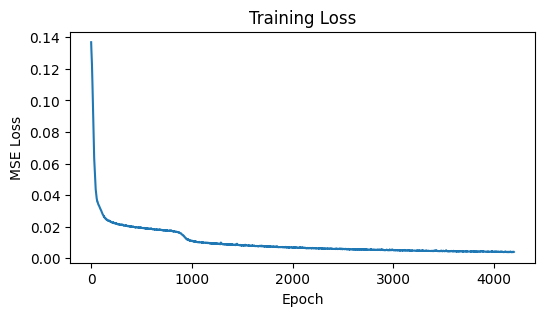

In [84]:
# Cell 4: Plot training loss
plt.figure(figsize=(6,3))
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

In [85]:
N = 100
x0_vis = x0_batch[:N]
x1_vis = x1_batch[:N]

z_mean, z_logvar = vae.encoder(x1_vis.to(device))
z_b = vae.reparameterize(z_mean, z_logvar)

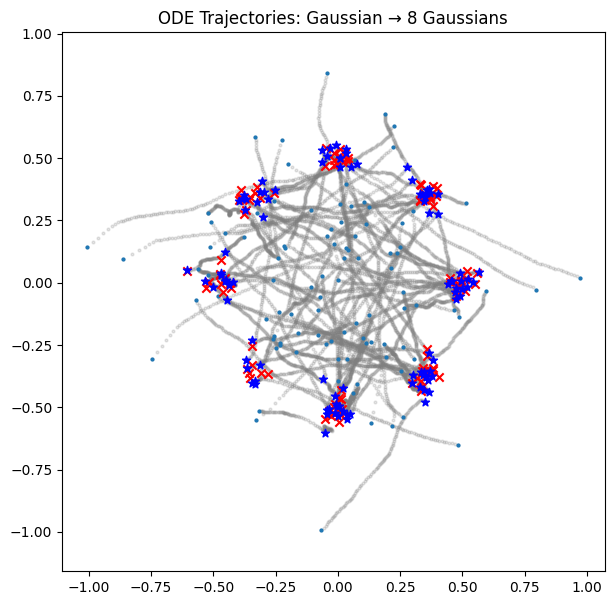

In [116]:

def euler_integration(x0, z, model, steps=100):
    x0 = x0.unsqueeze(0)
    traj = [x0]
    z = z.unsqueeze(0).to(device).to(x0.dtype)
    
    x = x0.clone().to(device)
    dt = 1.0 / steps
    for i in range(steps):
        t_i = torch.tensor([[i * dt]], device=device)
        with torch.no_grad():
            # print(t_i.shape, x.shape, z.shape)
            v = model(t_i, x, z)
        x = x + v * dt
        traj.append(x.cpu().numpy())
    return np.stack(traj).squeeze()

plt.figure(figsize=(7,7))

end_points = []
# class_k = 5
# z = torch.tensor([np.sin(class_k*np.pi/4), np.cos((8-class_k)*np.pi/4)])*1.5
for i in range(N):
    trajectory = euler_integration(x0_vis[i],z_b[i], model)
    plt.scatter(trajectory[:, 0], trajectory[:, 1], c='grey', marker='o', alpha=0.2, s=4)
    end_points.append(trajectory[-1])
end_points = np.array(end_points)

plt.scatter(x0_vis[:, 0], x0_vis[:, 1], label='Initial', marker='o', s=4)
plt.scatter(x1_vis[:, 0], x1_vis[:, 1], label='Target Mean', marker='x', c='r')
plt.scatter(end_points[:, 0], end_points[:, 1], label='Target Mean', marker='*', c='b')
plt.title("ODE Trajectories: Gaussian → 8 Gaussians")
plt.axis("equal")
plt.show()

In [130]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
import torch
import os

def generate_gif(model, x0_vis, x1_vis, z_b, steps=20, save_path="flow.gif", N=100):
    frames = []
    all_trajectories = []

    for i in range(N):
        traj = euler_integration(x0_vis[i],z_b[i], model, steps=steps)
        all_trajectories.append(traj)

    for step in range(steps + 1):
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_title(f"Flow step {step}")
        ax.scatter(x0_vis[:, 0], x0_vis[:, 1], label='Initial', marker='o', s=4)
        ax.scatter(x1_vis[:, 0], x1_vis[:, 1], label='Target Mean', marker='x', c='r')

        for traj in all_trajectories:
            if step < len(traj):
                ax.plot(traj[:step+1, 0], traj[:step+1, 1], color='grey', alpha=0.3)
                ax.scatter(traj[step, 0], traj[step, 1], marker='x', color='blue', s=10)

        ax.axis('equal')
        ax.legend()
        plt.tight_layout()

        
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        plt.close(fig)

   
    imageio.mimsave(save_path, frames, duration=0.1) 


generate_gif(model, x0_vis, x1_vis, z_b, steps=20, save_path="flow_trajectories.gif", N=100)


/tmp/ipykernel_3397574/3372428944.py:32: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


In [131]:
aux = torch.ones_like(z_b)
aux[:] = z_b[0]
generate_gif(model, x0_vis, x1_vis, aux, steps=20, save_path="flow_trajectories_conditioned.gif", N=100)

/tmp/ipykernel_3397574/3372428944.py:32: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
